## Görev 1: Spark Session Oluşturma ve csv'den Veri Okuma


- Adım 1: Gerekli Kütüphaneleri yükleyiniz ve gerekli jar dosyaları ile Spark Session oluşturunuz.


In [ ]:
import findspark
findspark.init("/opt/manual/spark")

from pyspark.sql import SparkSession, functions as F

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [ ]:
spark = (
    SparkSession.builder
    .appName("Spark-Cassandra-With-Catalog")
    .master("local[2]")
    .config("spark.driver.memory","2048m")
    .config("spark.sql.shuffle.partitions", 4)
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.0.0") 
    .config("spark.sql.extensions","com.datastax.spark.connector.CassandraSparkExtensions")
    .config("spark.sql.catalog.docker3nodescluster", 
            "com.datastax.spark.connector.datasource.CassandraCatalog")
    .config("spark.sql.catalog.docker3nodescluster.spark.cassandra.connection.host", 
            "127.0.0.1")
    .getOrCreate()
)

# Notes
# Serialization is used for performance tuning on Apache Spark. 
# All data that is sent over the network or written to the disk or persisted in the memory should be serialized. 
# Serialization plays an important role in costly operations.
# Kryo serialization: Spark can also use the Kryo library (version 4) to serialize objects more quickly. 
# Kryo is significantly faster and more compact than Java serialization (often as much as 10x), 
# but does not support all Serializable types and requires you to register the classes you’ll use in the program in advance for best performance.

- Adım 2: Veri setini okuyunuz.


In [ ]:
# Since we have limited resources we wil take sample

df = spark.read.format("csv") \
.option("header", True) \
.option("sep", ",") \
.option("inferSchema", True) \
.option("timestampFormat","yyyy-MM-dd HH:mm:ss.SSSSSS") \
.load("file:///home/train/datasets/iyzico_data.csv")

- Adım 3: Şemasını gözlemleyiniz.


In [ ]:
df.printSchema()

root
 |-- iyzico_data.csv                                                                                     0000664 0001750 0001750 04613461137 14176564341 013155  0                                                                                                    ustar   train                           train                                                                                                                                                                                                                  transaction_date: timestamp (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- total_paid_price: double (nullable = true)



- Adım 4: ilk sütun ismindeki hatayı düzeltiniz ve transaction_date olarak güncelleyiniz.


In [ ]:
df = df.withColumnRenamed(df.dtypes[0][0], 'transaction_date')

* Alternatif Çözüm

In [ ]:
#Kolon isimlerini düzenliyoruz(transaction_date kolonunun isimlendirilmesinde bir takım hatalar mevcuttu, düzenleme yapıldı) 

new_columns = ['transaction_date','merchant_id','category','total_paid_price']
df.toDF(*new_columns).printSchema()

df = df.toDF(*new_columns)

root
 |-- transaction_date: timestamp (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- total_paid_price: double (nullable = true)



- Adım 5: İlk 5 satırı gözlemleyiniz.


In [ ]:
df.limit(5).toPandas()

,transaction_date,merchant_id,category,total_paid_price
0,2018-01-01 00:00:20,124381,Gündelik Eşya Mağazaları,410.112
1,2018-01-01 00:01:34,124381,Gündelik Eşya Mağazaları,485.910
2,2018-01-01 00:02:03,124381,Gündelik Eşya Mağazaları,66.420
3,2018-01-01 00:04:34,124381,Gündelik Eşya Mağazaları,225.090
4,2018-01-01 00:04:36,46774,Emlak Ofisleri ve Yöneticileri - Kiralama,479.340


- Adım 6: Toplam satır sayısını gözlemleyiniz.


In [ ]:
df.count()

134189



## Görev 2: Cassandra Keyspace oluşturma

- Adım 1: Spark versiyonunu gözlemleyiniz.


In [ ]:
spark.version

'3.0.0'

- Adım 2: Notebook üzerinde bir keyspace oluşturunuz.


In [ ]:
spark.sql("CREATE DATABASE IF NOT EXISTS docker3nodescluster.iyzico \
  WITH DBPROPERTIES (class='SimpleStrategy', replication_factor='3')").show()

++
||
++
++



- Adım 3: Mevcut keyspaceleri gözlemleyiniz. 


In [ ]:
spark.sql("SHOW NAMESPACES FROM docker3nodescluster").show()

+------------------+
|         namespace|
+------------------+
|       system_auth|
|            iyzico|
|     system_schema|
|system_distributed|
|            system|
|     system_traces|
+------------------+





## Görev 3: Çoklanmış kayıtları kontrol etme.

- Adım 1: Aşağıdaki kod ile çoklanmış kayıtları kontrol edebilirsiniz.

`duplicates = df.groupBy('transaction_date', 'merchant_id', 'total_paid_price').count().alias('count') \
.filter('count > 1')`


In [ ]:
# Tekrar eden kayıtlara bakma
duplicates = df.groupBy('transaction_date', 'merchant_id', 'total_paid_price').count().alias('count') \
.filter('count > 1')


- Adım 2: Çoklanmış kayıt varsa bunları veri setinden çıkartınız. Bunun için distinct() kullanabilirsiniz.


In [ ]:
df2 = df.distinct()


- Adım 3: Yeni dataframe'in satır sayısını kontrol ediniz.


In [ ]:
df2.count()

134060


- Adım 4: Çoklanmış kayıtları tekrardan inceleyiniz.


In [ ]:
# Tekrar eden kayıtlara bakma
duplicates = df2.groupBy('transaction_date', 'merchant_id', 'total_paid_price').count().alias('count') \
.filter('count > 1')

## Görev 4: Spark SQL ile EDA

- Adım 1: `createOrReplaceTempView` ile geçici bir tablo oluşturunuz.


In [ ]:
# geçici bir tablo oluşturma
df2.createOrReplaceTempView("iyzico_tbl")

- Adım 2: Aşağıdaki soruları cevaplayınız.
    - Kaç Farklı Merchant Vardır?
    - Merchant kırılımında transaction sayıları nedir?
    - Kaç farklı kategori vardır?
    - Kategori kırılımında transaction sayıları nedir?
    - Günlere göre transaction sayıları nedir, ilk 10 gözlemi listeleyiniz.
    - transaction_date üzerinde kaç farklı gün vardır?


In [ ]:
# Kaç Farklı Merchant Vardır?
spark.sql("""
    
    SELECT COUNT(DISTINCT merchant_id) FROM iyzico_tbl

""").show()

+---------------------------+
|count(DISTINCT merchant_id)|
+---------------------------+
|                          7|
+---------------------------+



In [ ]:
# df2.groupBy("merchant_id").count().show()
df2.groupBy("merchant_id").count().show()

+-----------+-----+
|merchant_id|count|
+-----------+-----+
|        535|23088|
|      42616|29334|
|     124381|19504|
|      46774|30853|
|     129316| 5596|
|      86302| 3392|
|      57192|22293|
+-----------+-----+



In [ ]:
### Kaç farklı kategori vardır?
spark.sql("""
    
    SELECT COUNT(DISTINCT category) FROM iyzico_tbl

""").show()

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                       7|
+------------------------+



In [ ]:
# Kategori kırılımında transaction sayıları nedir?
spark.sql("""
    
    SELECT category, count(*) FROM iyzico_tbl
    GROUP BY category

""").toPandas()

,category,count(1)
0,Endüstriyel Malzemeler (Başka Yerde Sınıflandırılmamış),3392
1,Emlak Ofisleri ve Yöneticileri - Kiralama,30853
2,Profesyonel Hizmetler,23088
3,Çeşitli Gıda Mağazaları - Bakkallar ve Özel Pazarlar,5596
4,Bilgisayar Yazılım Mağazaları,22293
5,Gündelik Eşya Mağazaları,19504
6,"Kadın,Erkek Giyim Magazaları",29334


In [ ]:
# Günlere göre transaction sayıları nedir, ilk 10 gözlemi listeleyiniz.
transaction_date_gby = spark.sql("""

    SELECT DATE(transaction_date) trans_day, COUNT(1) 
    FROM iyzico_tbl
    GROUP BY trans_day
    
""").toPandas()

transaction_date_gby.head(10)

,trans_day,count(1)
0,2018-01-02,3531
1,2018-01-03,8077
2,2018-01-20,3611
3,2018-01-22,4184
4,2018-01-25,3662
5,2018-01-28,2427
6,2018-01-31,4475
7,2018-02-01,4487
8,2018-02-02,4395
9,2018-02-04,435


<AxesSubplot:ylabel='trans_day'>

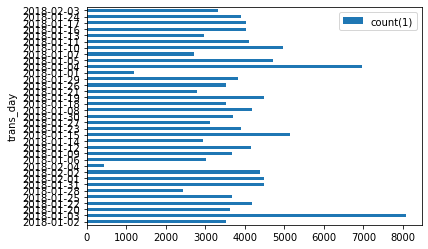

In [ ]:
transaction_date_gby.plot.barh(x='trans_day', y='count(1)')

In [ ]:
# transaction_date üzerinde kaç farklı gün vardır?
spark.sql("""
    
    SELECT COUNT(DISTINCT DATE(transaction_date)) FROM iyzico_tbl

""").show()

+----------------------------------------------+
|count(DISTINCT CAST(transaction_date AS DATE))|
+----------------------------------------------+
|                                            35|
+----------------------------------------------+




- Adım 3: transaction_date sütunundaki gün bilgisi ile trans_day adında yeni bir değişken oluşturunuz.


In [ ]:
df3 = df2.withColumn("trans_day", F.to_date("transaction_date"))


- Adım 4: Eşsiz trans_day ve merchant_id sayısı nedir, inceleyiniz.


In [ ]:
spark.sql("""
    
    SELECT COUNT(DISTINCT DATE(transaction_date), merchant_id) FROM iyzico_tbl

""").show()

+-----------------------------------------------------------+
|count(DISTINCT CAST(transaction_date AS DATE), merchant_id)|
+-----------------------------------------------------------+
|                                                        240|
+-----------------------------------------------------------+




## Görev 5: Spark ile Cassandra Tablosu Yazma

- Adım 1: Spark ile Cassandra üzerinde bir keyspace oluşturunuz.
- Adım 2: Aşağıdaki iki önemli iş ihtiyacına uygun şekilde bir tablo oluşturunuz.
    - Veri seti geriye dönük olarak sorgulanmak isteniyor.
    - Aynı gün içinde kayıtlara tarih sırasına göre erişme ihtiyacı vardır
- Adım 3: Spark ile veriyi bu tabloya yazınız.



In [ ]:
spark.sql("""DROP TABLE IF EXISTS docker3nodescluster.iyzico.merchant_transactions """)

DataFrame[]

In [ ]:
spark.sql(""" CREATE TABLE IF NOT EXISTS docker3nodescluster.iyzico.merchant_transactions (
transaction_date timestamp,
merchant_id int,
category string,
total_paid_price double,
trans_day date
) 
  USING cassandra
  PARTITIONED BY (trans_day)
  TBLPROPERTIES ( clustering_key='transaction_date.desc, merchant_id.asc, total_paid_price',
                  compaction='{class=SizeTieredCompactionStrategy,bucket_high=1001}') 
""")

DataFrame[]

In [ ]:
# set consistency level
spark.conf.set("spark.cassandra.output.consistency.level", "LOCAL_ONE")

from datetime import datetime

start_time = datetime.now()

df3.write.mode("append") \
.format("org.apache.spark.sql.cassandra") \
.saveAsTable("docker3nodescluster.iyzico.merchant_transactions")

end_time = datetime.now()

print(end_time - start_time)

0:00:17.817859




## Görev 6: Spark ile Cassandra Tablosunu Okuma

- Adım 1: Yazma işleminden sonra Spark ile Cassandra tablosunu okuyunuz.


In [ ]:
df_from_cassandra = spark.read.table("docker3nodescluster.iyzico.merchant_transactions")

df_from_cassandra.limit(5) \
.toPandas()

,trans_day,transaction_date,merchant_id,total_paid_price,category
0,2018-01-13,2018-01-13 23:59:37,42616,113.130,"Kadın,Erkek Giyim Magazaları"
1,2018-01-13,2018-01-13 23:59:36,42616,23.310,"Kadın,Erkek Giyim Magazaları"
2,2018-01-13,2018-01-13 23:58:57,57192,58.392,Bilgisayar Yazılım Mağazaları
3,2018-01-13,2018-01-13 23:58:49,57192,84.366,Bilgisayar Yazılım Mağazaları
4,2018-01-13,2018-01-13 23:58:38,46774,684.432,Emlak Ofisleri ve Yöneticileri - Kiralama


#### Partition ile sorgu

- Adım 2: 2018-01-17 tarihine ait kayıtları ekrana yazdırınız, kaç kayıt olduğunu bulunuz ve sorgunun süresini hesaplayınız.


In [ ]:
one_partition = spark.sql(""" 

SELECT * FROM docker3nodescluster.iyzico.merchant_transactions
Where trans_day = '2018-01-17'

""")

In [ ]:
start_time = datetime.now()

print(one_partition.count())

end_time = datetime.now()

print(end_time - start_time)

4017
0:00:04.774954



#### Partition olmadan sorgu
- Adım 3: `category = 'Bilgisayar Yazılım Mağazaları'` olan kayıtları ekrana yazdırınız, kaç kayıt olduğunu bulunuz ve sorgunun süresini hesaplayınız.



In [ ]:
a_category = spark.sql(""" 

SELECT * FROM docker3nodescluster.iyzico.merchant_transactions
where category = 'Bilgisayar Yazılım Mağazaları'

""")

In [ ]:
start_time = datetime.now()

print(a_category.count())

end_time = datetime.now()

print(end_time - start_time)

22293
0:00:08.942664
